# Style Transfer

Style Transfer with the VGG19 model

In [1]:
%matplotlib inline
#import cv2
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Download the pretrained model
vgg = models.vgg19(pretrained = True).features
# Freeze parameters
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
# Create variable to allow torch to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [4]:
# Define a function to load the image
def load_image(img_path, max_size = 400, shape = None):
    image = Image.open(img_path).convert('RGB')
    # Check if the dimensions of the image are larger than the specified value
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
        
    # Create the transformations to be applied to the image
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    image = in_transform(image).unsqueeze(0)
    
    return image

In [5]:
# Import the images
content = load_image("./san_basilio.jpeg").to(device)
style = load_image("./impressionism.jpg", shape = content.shape[-2:]).to(device)

In [6]:
# Define a function to conver the image(Tensor) to numpy
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

(-0.5, 399.5, 473.5, -0.5)

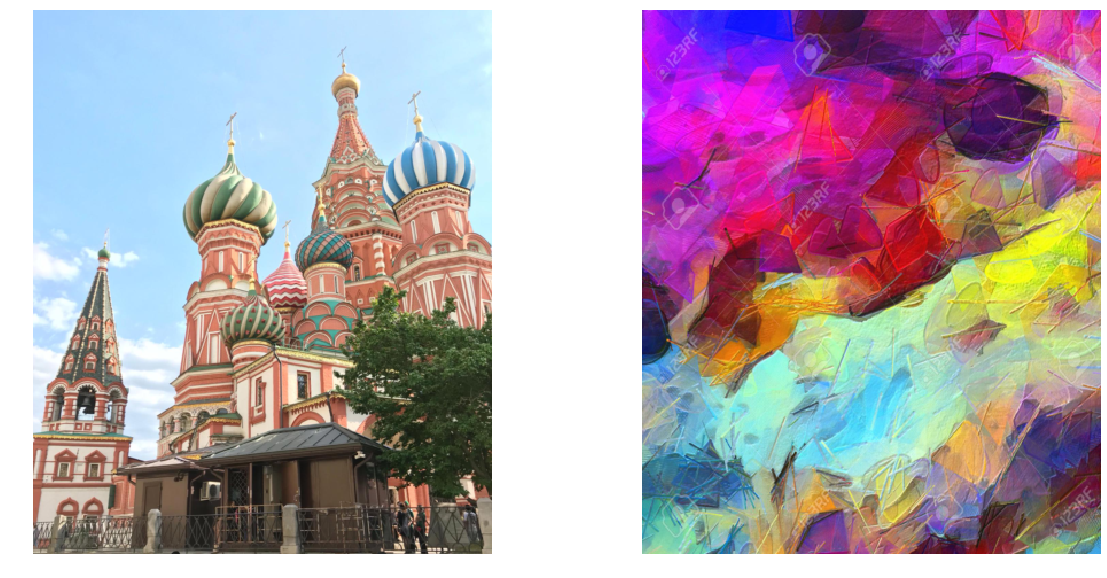

In [7]:
# Upload and plot both the content and style images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

In [8]:
# Define the functions to get features from the images
def get_features(image, model):
    
    layers = {'0': 'conv1_1', 
             '5': 'conv2_1', 
             '10': 'conv3_1', 
             '19': 'conv4_1', 
             '21': 'conv4_2', # Content extraction
             '28': 'conv5_1'}
    
    features = {}
    
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
            
    return features

In [9]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [10]:
# Define function to apply the gram matrix
def gram_matrix(tensor):
    # unpack the four dimensions of the tensor
    # b = batch size (this is ignored with _), d = image depth, h = image height, w = image width
    _, d, h, w = tensor.size()
    # Reshape the tensor into a 2-dimensional one
    tensor = tensor.view(d, h * w)
    # Multiply the tensor with its own transpose to get the gram matrix
    gram = torch.mm(tensor, tensor.t())
    return gram

In [11]:
# Apply the gram matrix to the style features extracted
# Map each layer to the gram matrix of its corresponding feature
# Use a dictionary comprehension to achieve this
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [12]:
style_weights = {'conv1_1': 1.,
                'conv2_1': .75,
                'conv3_1': 0.2,
                'conv4_1': 0.2,
                'conv5_1': 0.2}

content_weight = 1
style_weight = 1e6

In [13]:
# Define the target image
target = content.clone().requires_grad_(True).to(device)

In [14]:
# Define parameters for the training process
show_every = 300
optimizer = optim.Adam([target], lr = 0.003)
steps = 3000
# Define the parametres for data visualization
height, width, channels = im_convert(target).shape
image_array = np.empty(shape = (300, height, width, channels))
capture_frame = steps/300
counter = 0

Total loss:  3515823.0
Iteration:  300


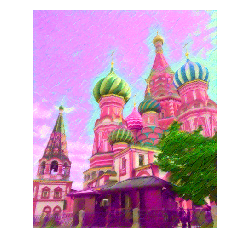

Total loss:  1060310.5
Iteration:  600


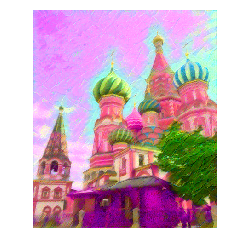

Total loss:  491450.5
Iteration:  900


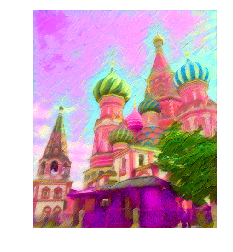

Total loss:  350894.46875
Iteration:  1200


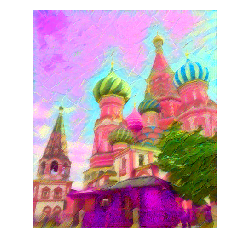

Total loss:  265411.90625
Iteration:  1500


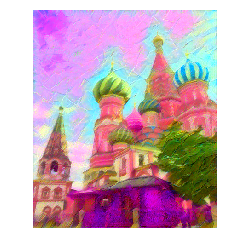

Total loss:  206953.71875
Iteration:  1800


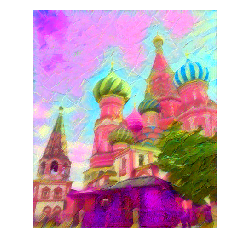

Total loss:  165955.015625
Iteration:  2100


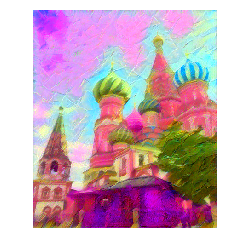

Total loss:  135078.90625
Iteration:  2400


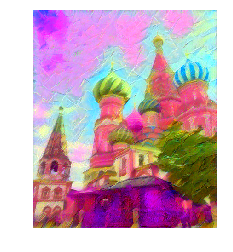

Total loss:  110532.4140625
Iteration:  2700


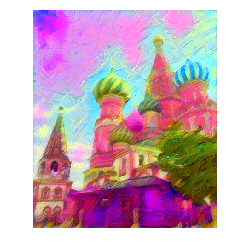

Total loss:  90678.8125
Iteration:  3000


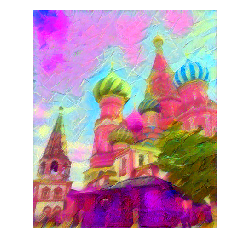

In [15]:
# Write the optimization process
for ii in range(1, steps +1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    style_loss = 0
    
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_loss * content_weight + style_loss * style_weight
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # Add code for data visualization
    # Ensures to plot the image every 300 iterations
    if ii % show_every == 0: 
        print('Total loss: ', total_loss.item())
        print('Iteration: ', ii)
        plt.imshow(im_convert(target))
        plt.axis('off')
        plt.show()
    # compare the ii iteration with the capture frame
    # This allows to create a video that shows how the image evolves through the iterations
    if ii % capture_frame == 0:
        image_array[counter] = im_convert(target)
        counter += 1    

(-0.5, 399.5, 473.5, -0.5)

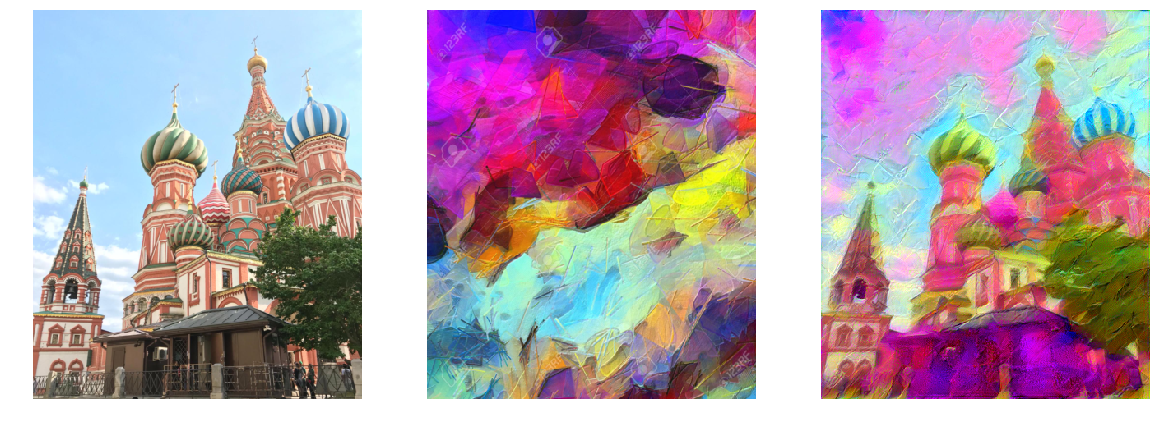

In [16]:
# Visualize the content, style, and target images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

(-0.5, 399.5, 473.5, -0.5)

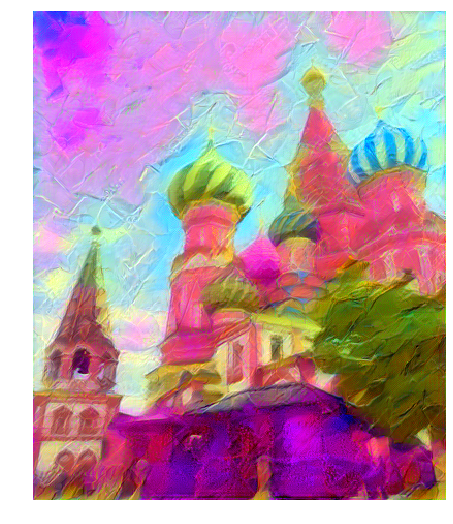

In [20]:
fig, (ax1) = plt.subplots(1, 1, figsize = (9, 9))
ax1.imshow(im_convert(target))
ax1.axis('off')

In [ ]:
# # Export the video of the evolution of the transformation
# frame_height, frame_width, _ = im_convert(target).shape
# vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

# # Run a loop to put each one of the 300 images into the video
# # The order of the lines is important
# for i in range(0, 300):
#     img = image_array[i]
#     # Remove the normalization of the image
#     img = img * 255
#     # Convert the array to integers
#     img = np.array(img, dtype = np.uint8)
#     cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     vid.write(img)

# # Close vid and release the video
# vid.release()